<img 
    style="position: absolute; 
           left: 60%; 
           top: 0; /* Added to ensure proper positioning */
           height: 900px; 
           width: 40%; /* Maintain the original width */
           object-fit: cover; /* Adjust if necessary */
           clip-path: inset(0px 50px 0px 50px round 10px);" 
    src="https://www.mathworks.com/help/examples/stats/win64/ParellelBayeianOptimizationExample_01.png" 
/>
</figure>


<h1 style="width: 60%; color: #EC6842; font-size: 55pt;">
    <Strong>
        Bayesian optimization in Truss structures optimisation
    </Strong>
</h1>

<h2 id="Background"><B>
    Rationale for the project<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>
<p style="text-align: justify; width: 60%; font-weight: normal;">
     Structures that make optimal use of the material they are made of reduces the cost and environmental impact of their construction as the amount of material required. Optimization of structural design is a challenging task because of the high number of design parameters and the relatively expensive evaluation of the suitability of any given design. Standard optimization techniques in high-dimensional design space require a very large number of possible designs that need to be evaluated. In structural analysis, where evaluating the objective function and checking the constraints involves the solution of a structural mechanics problem, e.g. with finite elements, this quickly becomes very expensive, even if the model is relatively simple from structural point of view. Bayesian optimization is a machine-learning-based optimization technique that aims to reduce the number of evaluations of the objective function through data-driven exploration of the design space with a probabilistic surrogate.
</p>

<h2 id="Background">
    <B>Objective & Description:</B><a class="anchor-link" href="#Background">&#182;</a>
</h2>

<div style="width: 60%; border-top: 4px solid #00B8C8; border-left: 4px solid #00B8C8; background-color: #FFFFFF; padding: 1em 1em 1em 1em; color: #24292E; margin: 10px 0 20px 0; box-sizing: border-box;">
    <div style="background-color: #00B8C8; color: white; padding: 0.2em 1em; margin: -1em -1em 0em -1em; font-size: 1.2em;"><strong>Project Objective:</strong> To find the optimal truss design</div>
    <p>
    To achieve so this project requires to find the optimal set of nodal coordinates and cross-sectional properties. Achieving so will allow to minimize as much as possible the total weight of the structure, while satisfying a number of constraints relating to the structures natural frequencies. Achieving a low mass solutions that also satisfies the natural frequencies constraints established demonstrates a methodology to make structures more efficient and safe since we are achieving to use less material in a way that still ensures the structural integrity of the structure. Moreover, this project will also aim to explore the efficacy of current optimisation methods and potentially improvements to be achieved from implementing machine learning methods.
    </p>
</div>

## <strong> X | Imports</strong>

In [1]:
import sys
import io
import os
import pickle
import numpy as np
import pandas as pd
import torch

In [3]:
# ----------------------------------- BOPT ----------------------------------- #
from botorch.utils.transforms import normalize
from botorch.utils.transforms import unnormalize
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from tabulate import tabulate
from contextlib import redirect_stdout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [4]:
# ------------------------------- LOCAL IMPORTS ------------------------------ #
sys.path.append('../TRUSS1/truss_bridge')
from dash import Dash, dcc, html, Input, Output
from TRUSS_convergence import plot_truss_layout, get_truss_data_for_iteration, loss_function_figure

sys.path.append('../TRUSS1/pyJive/')
import main
from utils import proputils as pu
from names import GlobNames as gn

## <strong> 0 | Classes & Dependencies</strong>

This project initially had two main classes:

1. **TRUSS**:
<br>A class primarily concerned with stroing the TRUSSES characteristics and processing function allowing for the manipulation either for optimisation or data exploration.
Most importantly this class also included the loss function from which the algorithm relies upon. The structure of this function is the following,

In [5]:
class TRUSS():
    def __init__(self, file_path, file_name, output_path, write_name, violation_penalty, scalers, bounds, lower_area=4e-3, freq_constraints=[20, 40, 60], mass_weight=1, freq_weight=1):
        # Configuration Parameters
        self.config = {
            "read_file_path": file_path,
            "read_file_name": file_name,
            "write_file_path": output_path,
            "write_file_name": write_name,
            "violation_penalty": violation_penalty,
            "scalers": {"y": scalers[0], "a": scalers[1]},
            "lower_area": lower_area,
            "bounds" : bounds,
            "freq_constraints": freq_constraints,
            "mass_weight": mass_weight,
            "freq_weight": freq_weight,
            "density": 7850,  # kg/m^3 As per Garnachos
        }

        self.state = {
            "nodes": {},
            "connectivity": None,
            "member_df": None,
            "y_coordinates": None,
            "x_coordinates": None,
            "cross_sections": None,
            "lengths": None,
            "mass_norm": 360,
            "monitor_df": None
        }

        self.columns = ["Metric", "Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation (Loss No W)"]
        self.state["monitor_df"] = pd.DataFrame(columns=self.columns)
    # -------------------------- Import & Writing Files -------------------------- #
    def read_geom_file(self):
        path = os.path.normpath(os.path.join(self.config["read_file_path"], self.config["read_file_name"]))
        with open(path, 'r') as file:
            lines = file.readlines()

        nodes = {}
        members = []
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith('node:'):
                section = 'node'
            elif line.startswith('member:'):
                section = 'member'
            else:
                if section == 'node' and line:
                    parts = line.split()
                    node_number = int(parts[0])
                    node_data = tuple(map(float, parts[1:]))
                    nodes[node_number] = node_data
                elif section == 'member' and line:
                    member_data = tuple(map(int, line.split()))
                    members.append(member_data)

        self.state["nodes"] = nodes
        self.state["member_df"] = pd.DataFrame(members, columns=['Node #1', 'Node #2', 'Number of Elements', 'Cross-section Type'])

        connectivity = self.state["member_df"].to_numpy()
        self.state["connectivity"] = connectivity[:, :2]
        self.state["y_coordinates"] = np.array([value[1] for _, value in nodes.items()])
        self.state["x_coordinates"] = np.array([value[0] for _, value in nodes.items()])

    def write_geom_file(self,path_,write_file): 
        path = os.path.normpath(os.path.join(path_,write_file))
        file = open(path)

        for i, (x, _) in self.state["nodes"].items():
            self.state["nodes"][i] = (x, self.state["y_coordinates"][i])

        geom = 'node: node #, x-coordinate; y-coordinate\n'
        for node_num, coords in self.state["nodes"].items():
            geom += f"{node_num} {' '.join(map(str, coords))}\n"
        
        connectivity = self.state["member_df"].to_numpy()
        geom += '\nmember: Node #1; Node #2; number of elements; cross-section type\n'
        for row in connectivity:
            geom += ' '.join(map(str, row)) + '\n'

        output_file_path = os.path.normpath(os.path.join(path_,'TRUSS.geom'))
        with open(output_file_path, 'w') as file:
            file.write(geom)
            
        return file.name
    
    def fit_scalers(self, initial_data):
        y_data = initial_data[:5].reshape(1, -1).T
        a_data = initial_data[5:].reshape(1, -1).T
        self.config["scalers"]["y"].fit(y_data)
        self.config["scalers"]["a"].fit(a_data)

    def scaler(self, mode, x_values, scaler_type):
        scaler = self.config["scalers"][scaler_type]
        x_values = x_values.reshape(1, -1).T
        if mode == 'scale':
            scaled_values = scaler.transform(x_values)
        elif mode == 'descale':
            scaled_values = scaler.inverse_transform(x_values)
        return scaled_values.flatten()
    
    def areas_coordinates_write_split(self, x_list):        
        y_coordinates = np.copy(self.state["y_coordinates"])  # Use a copy to avoid modifying the original array directly
        areas = x_list[5:]
        y_coords = x_list[:5]
        for i, y in enumerate(y_coords, start=1):
            y_coordinates[2 * i] = y
            y_coordinates[20 - 2 * i] = y

        self.state["y_coordinates"] = y_coordinates  # Update state

        return areas, y_coords
    # ---------------------------------------------------------------------------- #
    #                                TARGET FUNCTION                               #
    # ---------------------------------------------------------------------------- #
    def loss_function(self, x_list):
        """
        Calculate the loss for a given set of design parameters.
        Parameters:
        x_list (list): A list of design parameters.
        Returns:
        float: The calculated loss based on mass, frequency constraints, and imaginary penalties.
        """
        if isinstance(x_list,torch.Tensor):
            x_list = x_list.detach().cpu().numpy().flatten()
            self.temporary = x_list
        
        A_list, y_list = self.areas_coordinates_write_split(x_list)
        mass_truss = self.mass_truss(A_list, y_list)
        freq1, freq2, freq3 = self.eigenfrequencies(A_list)
        frequencies = np.array([freq1, freq2, freq3])

        freq_penalty = 0
        all_positive = True
        for f, t in zip(frequencies, self.config["freq_constraints"]):
            diff = f - t
            penalty_factor = 1 if diff >= 0 else self.config["violation_penalty"]
            freq_penalty += penalty_factor * (np.abs(diff) / t)
            if diff < 0:
                all_positive = False
        
        if all_positive:
            self.state["mass_norm"] = min(mass_truss, self.state["mass_norm"])

        normalized_mass_penalty = (mass_truss - self.state["mass_norm"]) / self.state["mass_norm"]
        normalized_freq_penalty = freq_penalty / len(self.config["freq_constraints"])
        constraint_violation = normalized_freq_penalty + normalized_mass_penalty

        LOSS = (self.config["mass_weight"] * normalized_mass_penalty +
                self.config["freq_weight"] * normalized_freq_penalty)
        # -------------------------- Optimisation monitoring ------------------------- #
        optmonitor_data = [
            ["Metric","Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation (Loss No W)"],
            ["Value",LOSS, frequencies, mass_truss, normalized_mass_penalty, normalized_freq_penalty, constraint_violation]
        ]
        print(f'{tabulate(optmonitor_data, headers="firstrow", tablefmt="grid")}\n')
        
        row_data = optmonitor_data[1][0:]
        new_data = pd.DataFrame([row_data], columns=self.columns)
        self.state["monitor_df"] = pd.concat([self.state["monitor_df"], new_data], ignore_index=True)
         
        return LOSS

    # ----------------------------- SUPPORT FUNCTIONS ---------------------------- #
    def eigenfrequencies(self,A_list):
        path = os.path.normpath(os.path.join(self.config["read_file_path"], 'bridge_frequency.pro'))
        
        props = pu.parse_file(path)
        props['model']['truss']['area'] = A_list
        props['init']['mesh']['file'] = self.write_geom_file(self.config["write_file_path"], self.config["write_file_name"])
        
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props)
        
        return (globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)

    def mass_truss(self,areas, y_list):
        x_coordinates = self.state["x_coordinates"]
        y_coordinates = self.state["y_coordinates"]
        
        for i, y in enumerate(y_list, start=1):
            y_coordinates[2 * i] = y
            y_coordinates[20 - 2 * i] = y

        coordinates = list(zip(x_coordinates, y_coordinates))
        lengths = np.zeros(len(self.state["connectivity"]))
        for i, (node1, node2) in enumerate(self.state["connectivity"]):
            x1, y1 = coordinates[node1]  # Adjusting index to start from 0
            x2, y2 = coordinates[node2]
            lengths[i] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        n_elements = self.state["member_df"].iloc[:,2].sum()
        areas_i = np.zeros(n_elements)
        cross_section_number = self.state["member_df"].iloc[:,-1] 
        
        for i,item in enumerate(cross_section_number):
                areas_i[i] = areas[item]
        self.temporary = areas_i
        self.state["cross_sections"] = areas[:15]
        self.state["lengths"] = lengths

        volumes = lengths * areas_i
        total_volume = np.sum(volumes)
        dens = 7800
        mass = total_volume * dens

        return mass
    # ----------------------------------- OTHER ---------------------------------- #
    def Write_call_state(self, x, final= True):
        if final:
            mask = self.state["monitor_df"]["Natural Frequencies"][:].apply(lambda x: (x >= self.config["freq_constraints"]).all())
            ind = self.state["monitor_df"][mask]["Mass of Truss"].idxmin()
            min_mass_iter = self.state["monitor_df"].iloc[ind]
            x_update = unnormalize(x[ind], bounds= self.config["bounds"].T)
        else:
            x_update = unnormalize(x, bounds= self.config["bounds"].T)
        # ------------------------------- Update state ------------------------------- #
        areas ,y_coords = self.areas_coordinates_write_split(x_update) # Serves to update coordinates
        _ = self.mass_truss(areas, y_coords) # Serves to update cross_sections and lengths
        path_wr = self.write_geom_file(self.config["write_file_path"], 'TRUSS.geom') # Serves to update GEOM
        # --------------------------------- Call geom -------------------------------- #
        path = os.path.normpath(os.path.join(self.config["write_file_path"],'bridge_frequency_truss.pro'))
        props = pu.parse_file(path)
        props['model']['truss']['area'] = self.state["cross_sections"]
        props['init']['mesh']['file'] = path_wr
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props)
        if final:
            print(f'TRUSS NFs:{(globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)} and Mass:{min_mass_iter}')

    def Initial_guess(self, optim_dims):
        sampled_points = np.zeros(len(optim_dims))
        for i, dim_index in enumerate(optim_dims):
            lower_bound, upper_bound = self.config["bounds"][i]
            sampled_points[i] = np.random.uniform(lower_bound, upper_bound)
        return sampled_points
    
    def objective_function(self, x):
        """
        Evaluates the objective function using another object's method.
        """
        return self.loss_function(x)
    

2. **Bayesian optimiser**: 
<br>A class which was the self-developed optimiser originally intended to use. Due to project time constraints this was left aside since the convergence time of this solution was not so good and more resembled and informed random walk. Furhter exploration of the behaviour of the optimiser seemed to show difficulties in the gaussian process in capturing the uncertainty in the multi-dimensional solution space which did not allow for efficient exploration.

    The code for the TRUSS´s project bayesian optimiser class can be found in [TRUSS BOPT](truss_bridge/TRUSS_Bopt.py)

## <strong> 1 | Inititation of objects and attributes</strong>

In [5]:
# -------------------------------- Definitions ------------------------------- #
read_file_path = '../TRUSS1/truss_bridge/data'
read_file = 'bridge.geom'
write_file_path =  '../TRUSS1/truss_bridge/data/@TRUSS'
write_file = 'TRUSS.geom'
optim_dims = [i for i in range(20)]  
lower_area = 40e-4
violation_factor = 6
freq_constraints = [20,40,60]
mass_weight = 2.5
freq_weight = 6.0
A_bound = (0.0001, 0.01)
y_bound = (0.5, 2)
scalers = [MinMaxScaler(),MinMaxScaler()] 
bounds = np.array([y_bound if index <= 4 else A_bound for index in optim_dims])
bounds[5] = (lower_area - A_bound[0], lower_area + A_bound[0])

TRUSS1= TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSS1.read_geom_file()

In [6]:
# -------------------------------- Initiation -------------------------------- #
n_samples =  10
x_list = []
y_list = []
x_list_sc = []
x_0 = np.empty(len(optim_dims))

for _ in range(n_samples):
    x_c = np.copy(x_0) # Reset seed
    x_random = TRUSS1.Initial_guess(optim_dims)
    x_c[optim_dims] = x_random
    x_list.append(x_c)
# 
trap = io.StringIO()
with redirect_stdout(trap):
    for x in x_list:
        LOSS = TRUSS1.loss_function(x)
        y_list.append(LOSS)
# 
# ---------------------------- INITIATE OPTIMISER ---------------------------- #
bounds = torch.tensor(bounds.T)  
y_init_t = torch.tensor(y_list).reshape(-1,1)

## <strong> 2 | Optimisation </strong>

### <strong> 2.1 | Single task Optimisation </strong>

After some experimentation the best performing algorithm despite not having or relying on as strong probabilistic interpretation as the SAAS model. This has been true for this dimension space since the computational complexity of the probabilistic model dowgrades its convergence time, in other words the searched solution space can be solved through a simpler bayesian optimisation approach. Other findings included how the algorithm coverges faster to a solution with smaller batch sizes this is potentially since the bounds and constraints introduced are already quite small and also potentially indicating there isnt that many locations with local minima and therefore a smoother overall solution space.

In [7]:
def SingleBOPT(Y_init_single, X_init_single, n_iter, batch_size, Nrestats, objective_function):
    gp_model = SingleTaskGP(X_init_single, Y_init_single)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)
    gp_model.set_train_data(inputs=X_init_single, targets=Y_init_single.flatten(), strict=False)
    
    for iteration in range(n_iter):
        print(f'Iteration: {iteration} Best loss = {Y_init_single.min().item():.2f}\n')
        acq_func = ExpectedImprovement(model=gp_model, best_f=Y_init_single.min(), maximize=False)
        new_x, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,
            num_restarts= Nrestats,
            raw_samples= batch_size,
        )
        new_x_unnorm = unnormalize(new_x, bounds=bounds)
        new_y = objective_function(new_x_unnorm)
        new_y = torch.tensor(new_y, dtype=torch.float32).reshape(1,-1)
        X_init_single = torch.cat([X_init_single, new_x])
        Y_init_single = torch.cat([Y_init_single, new_y])
        
        gp_model.set_train_data(inputs=X_init_single, targets=Y_init_single.flatten(), strict=False)
        fit_gpytorch_model(mll)
    return X_init_single, Y_init_single

Through the following cell we run the BOPT,

In [ ]:
objective_function = TRUSS1.loss_function
n_iter = 50
batch_size = 15
Nrestats = 10

X_init_single , Y_init_single = SingleBOPT(Y_init_single, X_init_single, n_iter, batch_size, Nrestats, objective_function)

### <strong> 2.2 | Read and Write Data </strong>

In [5]:
# -------------------------- SAVE DATA !!DO NOT RUN -------------------------- #
# file_name = "TRUSS1_bopt_data.pkl"
# path_s = os.path.normpath(os.path.join(write_file_path, file_name))

# data_single = {
#     "Y_init_single": Y_init_single,
#     "X_init_single": X_init_single,
#     "n_iter": n_iter,
#     "batch_size": batch_size,
#     "Nrestats": Nrestats,
#     "X_single": X_init_single,
#     "Y_single": Y_init_single,
#     "TRUSS": TRUSS1
# }
# data_to_save = [data_single]

# with open(path_s, 'wb') as file:
#     pickle.dump(data_to_save, file)

In [13]:
read_file_path = write_file_path =  '../TRUSS1/truss_bridge/data/@TRUSS/visualisation'
read_file = write_file = 'TRUSS.geom'

TRUSSDummy = TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSSDummy.read_geom_file()

file_name = "TRUSS1_bopt_data.pkl"
write_file_path =  '../TRUSS1/truss_bridge/data/@TRUSS/.pkl'
path_s = os.path.normpath(os.path.join(write_file_path, file_name))
with open(path_s, 'rb') as file:
    loaded_data = pickle.load(file)
# --------------------------------- variables -------------------------------- #
data_single = loaded_data[0]
Y_init_single = data_single["Y_init_single"]
X_init_single = data_single["X_init_single"]
n_iter = data_single["n_iter"]
batch_size = data_single["batch_size"]
Nrestats = data_single["Nrestats"]
X_init_single = data_single["X_single"]
Y_init_single = data_single["Y_single"]
TRUSSDummy = data_single["TRUSS"]

c:\Program Files\Python310\@Environments\TUD-JF\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## <strong> 3 | Results </strong>

### <strong> 3.1 | TRUSS Run </strong>

The following figure illustrates the explored truss shapes  by the bayesian optimiser in its convergence path. As a note, it can be seen that the lowest mass and the deemed best solution in the following code cells is not neccessarily the solution with the lowest loss function. This illustrates how there can still be improvements made to the loss function. 

In [14]:
total_loss = TRUSSDummy.state["monitor_df"]["Total Loss"]
TRUSSDummy.config["write_file_path"] = '../TRUSS1/truss_bridge/data/@TRUSS/visualisation'
fig = loss_function_figure(total_loss)

layout={
    'title': 'Hover over a point in the loss function to see the truss layout',
    'height': 500,  
    'width': 1000,  
    'plot_bgcolor': 'white',  
    'paper_bgcolor': 'white',  
}

app = Dash(__name__)
app.layout = html.Div([
    html.Div([
        dcc.Graph(id='truss-layout', figure=go.Figure()),  
    ], style={'display': 'inline-block', 'width': '55%'}),
    
    html.Div([
        dcc.Graph(id='loss-function', figure=fig),
    ], style={'display': 'inline-block', 'width': '40%'}),
], style={'width': '1500px'})

@app.callback(
    Output('truss-layout', 'figure'),
    [Input('loss-function', 'hoverData')]
)

def update_truss_layout(hoverData):
    if hoverData is not None:
        point_index = hoverData['points'][0]['pointIndex']
        nodes, member_df = get_truss_data_for_iteration(TRUSSDummy, X_init_single, point_index)
        return plot_truss_layout(nodes, member_df)
    return go.Figure(layout= layout)

In [15]:
app.run_server(debug=True)

### <strong> 3.2 | Investigating the variance in solution paths </strong>

Investigating the solution path we can observe how there is a very big variance between specific runs although this is moreso uncommon it demonstrates how unlike Kanarachos perhaps our Bopt solver is not as resilient to changing solution spaces. This is particularly an issue in our case since our solution space will change depending on the hyperparameters of our loss function. It is therefore important to account well for such behaviour.

In [10]:
num_runs = 5
n_iter_comparison = 50
# ------------------------- IMPORT ENSEMBLE LOOP DATA ------------------------ #
file_name = "TRUSS1_ensemble_data.pkl"
path_s = os.path.normpath(os.path.join(write_file_path, file_name))
with open(path_s, 'rb') as file:
    loaded_data = pickle.load(file)
    data = loaded_data[0]

results_single = data["results_single"]
mean_single =  data["mean_single"]
std_single = data["std_single"]

# ----------------------------- RUN ENSEMBLE LOOP ---------------------------- #
# results_single = np.zeros((num_runs, n_iter_comparison))
# Y_init_bpt , X_init_bpt = y_init_t, X_init_norm

# for i in range(num_runs):
#     _, Y_init_p = SingleBOPT(Y_init_bpt, X_init_bpt, n_iter_comparison, batch_size, Nrestats)
#     results_single[i, :] = Y_init_p[n_samples:].flatten()
# mean_single = np.mean(results_single, axis=0)
# std_single = np.std(results_single, axis=0)

results_single = results_single.T  
mean_single = results_single.mean(axis=1)
std_single = results_single.std(axis=1)
confidence_interval = 1.96 * (std_single / np.sqrt(num_runs))

In [17]:
base_color = 'rgba(30, 136, 229,'  # RGB for blue, with variable opacity

fig = go.Figure()
for i in range(num_runs):
    fig.add_trace(go.Scatter(
        x=np.arange(n_iter_comparison),
        y=results_single[:, i],
        mode='lines',
        name=f'Run {i+1}',
        line=dict(color=f'{base_color} {0.2 + (i / num_runs) * 0.5})')  # varying opacity
    ))

fig.add_trace(go.Scatter(
    x=np.arange(n_iter_comparison),
    y=mean_single,
    mode='lines',
    name='Mean Loss',
    line=dict(color='black', dash='dash')
))

fig.add_trace(go.Scatter(
    x=np.concatenate((np.arange(n_iter_comparison), np.arange(n_iter_comparison)[::-1])),
    y=np.concatenate((mean_single + confidence_interval, (mean_single - confidence_interval)[::-1])),
    fill='toself',
    fillcolor='rgba(200, 200, 200, 0.3)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name='Confidence Interval'
))

fig.update_layout(
    title="Optimization Runs with Mean and Confidence Intervals",
    xaxis=dict(
        title="Iteration",
        showline=True,
        showgrid=True,
        gridcolor='rgba(211, 211, 211, 0.8)',  
        linecolor='rgba(150, 150, 150, 0.8)',  
        linewidth=1,
        ticks='outside',
        tickfont=dict(
            size=12,
            color='black'
        ),
        gridwidth=1,
    ),
    yaxis=dict(
        title="Loss",
        showline=True,
        showgrid=True,
        gridcolor='rgba(211, 211, 211, 0.8)',  
        linecolor='rgba(150, 150, 150, 0.8)',  
        linewidth=1,
        ticks='outside',
        tickfont=dict(
            size=12,
            color='black'
        ),
        gridwidth=1,
    ),
    plot_bgcolor='white',
    width=1500,
    height=650,
    legend_title_text='Runs',
    legend_font_size=12,
    margin=dict(l=100, r=100, t=100, b=100),  
)
fig.show()















































































































## <strong> 4 | Benchmarking against Karnachos </strong>

### <strong> 4.0 | Initial Truss layout </strong>

In [25]:

np.mean(globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)

29.503239674440035

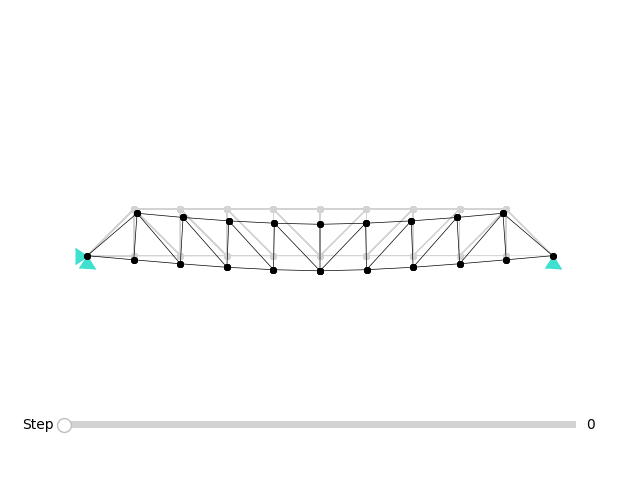

MASS: 336.2908657865102 kg  Natural Frequencies:[ 8.90649126 29.59101061 50.01221715] Hz


In [21]:
# ----------------------------- KANARACHOS TRUSS ---------------------------- #
%matplotlib widget
read_file_path = write_file_path =  '../TRUSS1/truss_bridge/data'

path_pro = os.path.normpath(os.path.join(read_file_path, 'bridge_frequency.pro'))
props = pu.parse_file(path_pro)

path_geom = os.path.normpath(os.path.join(read_file_path, 'bridge.geom'))
props['model']['truss']['area'] = props['model']['truss']['area'] = [4e-3,1e-4,1e-4,1e-4,1e-4,1e-4,1e-4,1e-4,1e-4,1e-4,1e-4,1e-4,1e-4,1e-4,1e-4]
props['init']['mesh']['file'] = path_geom

trap = io.StringIO()
with redirect_stdout(trap):
    globdat = main.jive(props)

# -------------------------- Initiate Initial truss -------------------------- #
read_file = 'bridge.geom'
write_file_path =  None
write_file = None
violation_factor = None
freq_constraints = None
mass_weight = None
freq_weight = None
scalers = [None,None]
bounds = None

TRUSS_initial = TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSS_initial.read_geom_file()

y_coord = TRUSS_initial.state["y_coordinates"][::2][1:6]
areas_initial = np.array(props['model']['truss']['area'])
print(f'MASS: {TRUSS_initial.mass_truss(areas_initial, y_coord)} kg  Natural Frequencies:{(globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)} Hz')

### <strong> 4.1 | Final Trusses & Basic statistics </strong>

The following are the displays of both solutions from Kanarachos et al., 2017 and TRUSS we can see that the overall shape is similar and as expected forms an incresingly round shape. By contrast the locations of members mass differ between trusses. Why this is the case is not entirely clear but for now it is understood that this is dominated by the converged solution iteration. 

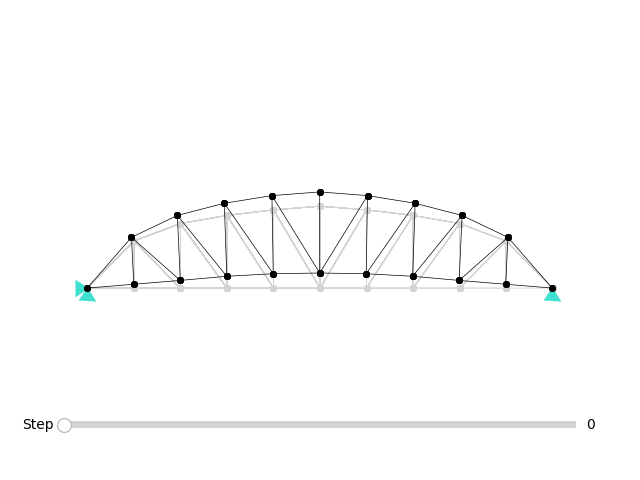

MASS: 360.07710670521664 kg  Natural Frequencies:[20.06682059 40.53905183 61.8225322 ] Hz


In [16]:
# ----------------------------- KANARACHOS TRUSS ---------------------------- #
%matplotlib widget
read_file_path = write_file_path =  '../TRUSS1/truss_bridge/data'

path_pro = os.path.normpath(os.path.join(read_file_path, 'bridge_frequency_kr.pro'))
props = pu.parse_file(path_pro)

path_geom = os.path.normpath(os.path.join(read_file_path, 'bridge_kanarachos.geom'))
props['model']['truss']['area'] = [ 40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]
props['init']['mesh']['file'] = path_geom

trap = io.StringIO()
with redirect_stdout(trap):
    globdat = main.jive(props)
# ------------------------ Initiate a Karnachos obect ------------------------ #
read_file_path = '../TRUSS1/truss_bridge/data'
read_file = 'bridge_kanarachos.geom'
write_file_path =  None
write_file = None
violation_factor = None
freq_constraints = None
mass_weight = None
freq_weight = None
scalers = [None,None]
bounds = None

TRUSSKN = TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSSKN.read_geom_file()

y_coord = TRUSSKN.state["y_coordinates"][::2][1:6]
areas_kn = np.array(props['model']['truss']['area'])
print(f'MASS: {TRUSSKN.mass_truss(areas_kn, y_coord)} kg  Natural Frequencies:{(globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)} Hz')

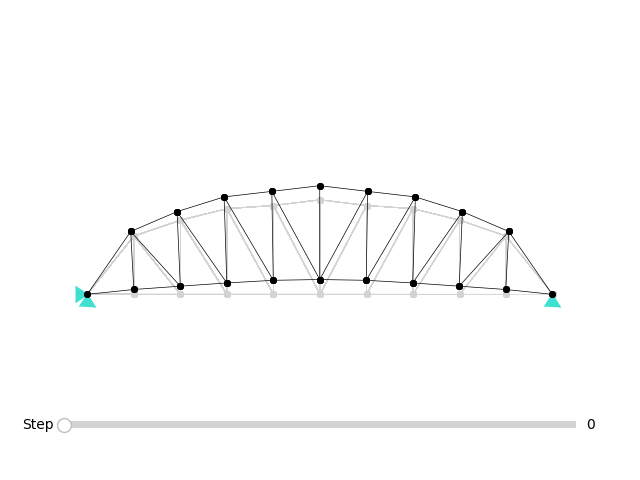

TRUSS NFs:[20.22004588 42.671595   61.82564151] and Mass:Metric                                                                          Value
Total Loss                                                                   0.249948
Natural Frequencies                 [20.22004587841629, 42.67159500288755, 61.8256...
Mass of Truss                                                              364.825316
Normalized Mass Loss                                                         0.013404
Frequency Penalty                                                            0.036073
Constraint Violation (Loss No W)                                             0.049477
Name: 37, dtype: object


In [17]:
# ---------------------------------- TRUSS1 ---------------------------------- #
TRUSSDummy.config["write_file_path"] = '../TRUSS1/truss_bridge/data/@TRUSS'
TRUSSDummy.Write_call_state(X_init_single)

### <strong> 4.2 | Comparing benchmarks </strong>

From the following benchmarks we can show how the converged solutions are quite similar the TRUSS solution performs better in meeting the NF constraints but not as well in optimising for the mass which is the preferred optimisation variable.This is in part because the TRUSS solution loss function has been hyperparametrised giving a higher weight to the natural frequencies. This is in the experience from multiple runs and hyperparameter optimisation led to a much gaster convergence but may also restrict the final ability of the model to find an even better solution. Additionally, we have been able to see in the loss function figure how the setup of the loss function could be improved since the loss function minima does not correspond with the best found solution. Therefore further refining in the loss function may even yield better results. 

In [17]:
mask = TRUSSDummy.state["monitor_df"]["Natural Frequencies"][:].apply(lambda x: (x >= TRUSS1.config["freq_constraints"]).all())
ind = TRUSSDummy.state["monitor_df"][mask]["Mass of Truss"].idxmin()
# ----------------------------------- Data ----------------------------------- #
TR_cs = TRUSSDummy.state["cross_sections"].numpy() #To Numpy on first run (Tensor format)
KN_cs = TRUSSKN.state["cross_sections"]

TR_m = TRUSSDummy.mass_truss(TR_cs, TRUSSDummy.state["y_coordinates"][::2][1:6])
KN_m = TRUSSKN.mass_truss(KN_cs, TRUSSKN.state["y_coordinates"][::2][1:6])

NFK = globdat[gn.EIGENFREQS][0:3]/2/np.pi
NFTR = TRUSSDummy.state["monitor_df"]["Natural Frequencies"][ind]

data = {
    'Model': ['Kanarachos model', 'TRUSS model'],
    'Cross Section Average [m^2]': [KN_cs.mean(), TR_cs.mean()],
    'Natural Frequency Average [rad/s]': [np.mean(NFTR), np.mean(NFK)],
    'Mass [kg]': [KN_m, TR_m],
    'Convergence time [s]': ['473', '315'],
}
basic_comp = pd.DataFrame(data)
basic_comp.set_index('Model', inplace=True)
basic_comp.index.name = None
basic_comp

,Cross Section Average [m^2],Natural Frequency Average [rad/s],Mass [kg],Convergence time [s]
Kanarachos model,0.000424,41.572427,360.077107,473
TRUSS model,0.000433,40.809468,364.825316,315


In [15]:
max_cross_sections = max(np.max(TR_cs), np.max(KN_cs))
normalized_cross_sections_model1 = TR_cs / max_cross_sections
normalized_cross_sections_model2 = KN_cs / max_cross_sections

max_mass = max(TR_m, KN_m)
normalized_mass_model1 = TR_m / max_mass
normalized_mass_model2 = KN_m / max_mass

max_nat_freq = max(np.max(NFTR), np.max(NFK))
normalized_nat_freq_model1 = np.array(NFTR) / max_nat_freq
normalized_nat_freq_model2 = np.array(NFK) / max_nat_freq
# ------------------------------------ VIS ----------------------------------- #
# Data for plotting
data = {
    "Metric": ["Cross Sections (Mean)", "Mass", "Nat. Freq. 1", "Nat. Freq. 2", "Nat. Freq. 3"],
    "Model 1 (TRUSS1)": [np.mean(normalized_cross_sections_model1), normalized_mass_model1] + normalized_nat_freq_model1.tolist(),
    "Model 2 (KANARACHOS)": [np.mean(normalized_cross_sections_model2), normalized_mass_model2] + normalized_nat_freq_model2.tolist()
}
dfbenchmark = pd.DataFrame(data)

In [16]:
fig = go.Figure()
colors = ['#00B8C8', '#EC6842']  

for i, model in enumerate(dfbenchmark.columns[1:]):
    fig.add_trace(go.Bar(
        x=dfbenchmark['Metric'],
        y=dfbenchmark[model],
        name=model,
        marker=dict(color=colors[i])
    ))

fig.update_layout(
    title="Comparison of Normalized Cross Sections, Mass, and Natural Frequencies",
    xaxis=dict(
        title="Metric",
        showgrid=True,  
    ),
    yaxis=dict(
        title="Normalized Value",
        showgrid=True,  
    ),
    plot_bgcolor='white',
    barmode='group',
    legend_title_text='Model',
    legend_font_size=12,
    margin=dict(l=100, r=100, t=100, b=100),
    template = "simple_white"  
)

fig.show()